**Step 1: Import Libraries**

We start by importing the necessary Python libraries for data manipulation, visualization, and machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE 

**Step 2: Load the Dataset**

Load the dataset into a Pandas DataFrame. Replace the file path with the actual location of your dataset in Kaggle.

In [2]:
# Load the training dataset
train_data = pd.read_csv("C:/Users/Mayank Goel/OneDrive/Desktop/ML Lab/fraudTrain.csv") 

# Load the testing dataset
test_data = pd.read_csv("C:/Users/Mayank Goel/OneDrive/Desktop/ML Lab/fraudTest.csv")

# Display the first few rows of both datasets
print("First 5 rows of the training dataset:")
print(train_data.head())

print("\nFirst 5 rows of the testing dataset:")
print(test_data.head())

First 5 rows of the training dataset:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F 

**Step 3: Exploratory Data Analysis (EDA)**

Perform basic exploratory analysis to understand the dataset.


Missing values in the training dataset:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Summary statistics for numeric columns in the training dataset:
         Unnamed: 0        cc_num           amt           zip           lat  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   6.483370e+05  4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01   
std    3.743180e+05  1.

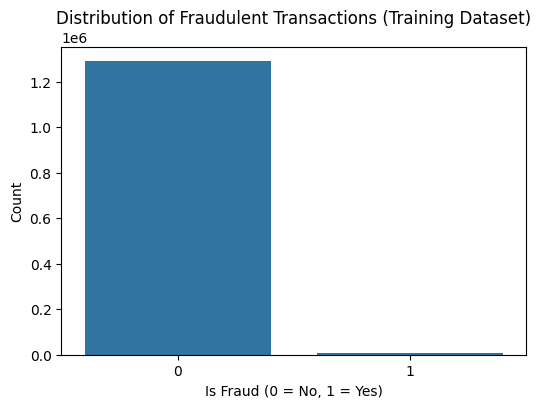

In [3]:
# Check for missing values in the training dataset
print("\nMissing values in the training dataset:")
print(train_data.isnull().sum())

# Summary statistics for numeric columns
print("\nSummary statistics for numeric columns in the training dataset:")
print(train_data.describe())

# Distribution of the target variable ('is_fraud') in the training dataset
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=train_data)
plt.title('Distribution of Fraudulent Transactions (Training Dataset)')
plt.xlabel('Is Fraud (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

**Step 4: Correlation Heatmap**

Compute and visualize the correlation matrix for numeric columns only.

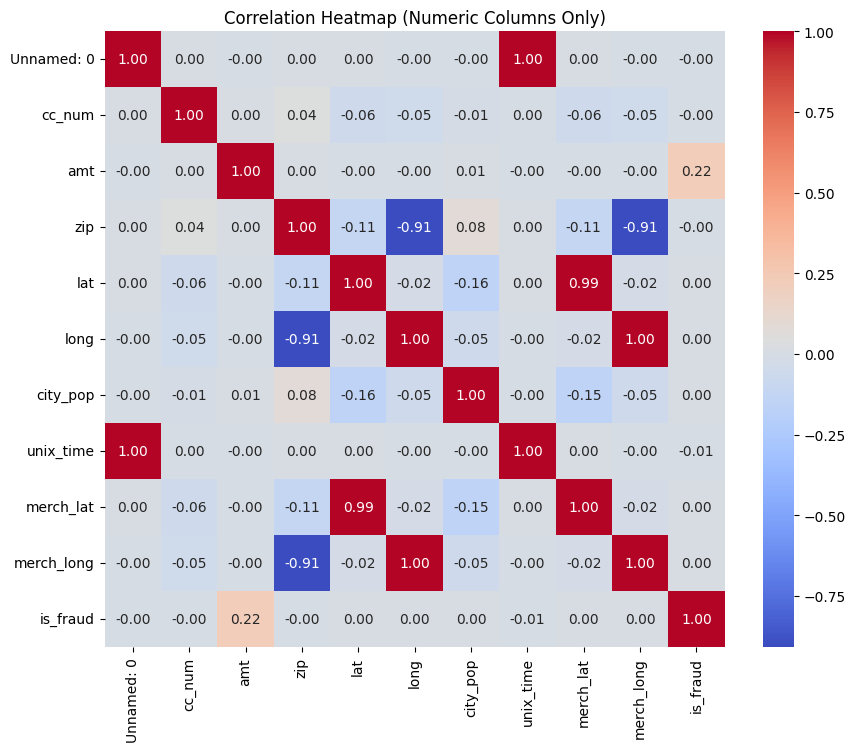

In [4]:
# Select only numeric columns for correlation analysis
numeric_data = train_data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numeric Columns Only)')
plt.show()

**Step 5: Feature Engineering**

Prepare the dataset for modeling by encoding categorical variables, scaling numerical features, and handling missing values.

In [5]:
# Drop unnecessary columns (only include columns that exist in the dataset)
columns_to_drop = ['trans_num', 'unix_time', 'first', 'last']
train_data.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

# Define features (X) and target (y) for the training dataset
X_train = train_data.drop('is_fraud', axis=1)  # Features (all columns except 'is_fraud')
y_train = train_data['is_fraud']  # Target variable ('is_fraud')

# Define features (X) and target (y) for the testing dataset
X_test = test_data.drop('is_fraud', axis=1)  # Features (all columns except 'is_fraud')
y_test = test_data['is_fraud']  # Target variable ('is_fraud')

# Dynamically identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Convert 'trans_date_trans_time' to datetime and extract features
if 'trans_date_trans_time' in X_train.columns:
    # Convert 'trans_date_trans_time' to datetime format
    X_train['trans_date_trans_time'] = pd.to_datetime(X_train['trans_date_trans_time'])
    X_test['trans_date_trans_time'] = pd.to_datetime(X_test['trans_date_trans_time'])

    # Extract useful features from 'trans_date_trans_time'
    X_train['hour'] = X_train['trans_date_trans_time'].dt.hour
    X_train['day'] = X_train['trans_date_trans_time'].dt.day
    X_train['month'] = X_train['trans_date_trans_time'].dt.month

    X_test['hour'] = X_test['trans_date_trans_time'].dt.hour
    X_test['day'] = X_test['trans_date_trans_time'].dt.day
    X_test['month'] = X_test['trans_date_trans_time'].dt.month

    # Drop the original 'trans_date_trans_time' column
    X_train.drop('trans_date_trans_time', axis=1, inplace=True, errors='ignore')
    X_test.drop('trans_date_trans_time', axis=1, inplace=True, errors='ignore')

    # Update categorical and numerical columns after preprocessing
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Encode categorical variables using LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    # Fit LabelEncoder on the union of train and test data to avoid unseen labels
    combined = pd.concat([X_train[col], X_test[col]])
    label_encoder.fit(combined)

    # Transform both train and test data
    X_train[col] = label_encoder.transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])  # Use transform (not fit_transform) for test data

# Ensure X_train and X_test have the same columns
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Print the final set of columns to verify
print("Final set of columns in X_train and X_test:")
print(X_train.columns)

Final set of columns in X_train and X_test:
Index(['Unnamed: 0', 'cc_num', 'merchant', 'category', 'amt', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'merch_lat', 'merch_long', 'hour', 'day', 'month'],
      dtype='object')


**Step 7: Train the model**

Train a Random Forest model on the training data.

In [6]:
# Initialize the Random Forest Classifier with optimized parameters
model = RandomForestClassifier(
    n_estimators=100,       # Reduce the number of trees
    n_jobs=-1,             # Use all available CPU cores
    random_state=42
)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

**Step 8: Evaluate the Model**

Evaluate the performance of the model using metrics like accuracy, precision, recall, and F1-score.

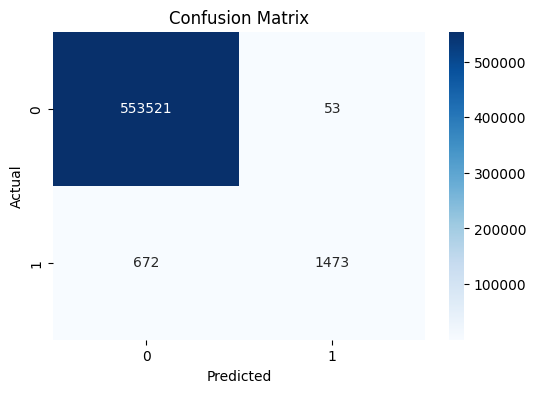


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.97      0.69      0.80      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.84      0.90    555719
weighted avg       1.00      1.00      1.00    555719

Accuracy: 1.00


In [7]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

**Step 9: Handle Class Imbalance**

If the dataset is imbalanced (e.g., more non-fraudulent transactions), apply SMOTE to balance the classes.

In [8]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(
    n_estimators=100,      
    n_jobs=-1,             
    random_state=42
)

# Train the model on the resampled data
model.fit(X_resampled, y_resampled)

# Make predictions on the test data
y_pred_resampled = model.predict(X_test)

# Evaluate the model again
print("\nClassification Report After SMOTE:")
print(classification_report(y_test, y_pred_resampled))


Classification Report After SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.58      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.79      0.81    555719
weighted avg       1.00      1.00      1.00    555719



**Step 10: Feature Importance**

Analyze which features are most important for detecting fraud.


Feature Importance:
       Feature  Importance
4          amt    0.571551
17        hour    0.098911
3     category    0.073530
1       cc_num    0.025069
14         dob    0.024526
0   Unnamed: 0    0.021597
19       month    0.021482
18         day    0.019975
12    city_pop    0.016933
6       street    0.014124
7         city    0.013672
13         job    0.012928
2     merchant    0.012539
10         lat    0.012275
9          zip    0.011682
16  merch_long    0.011365
15   merch_lat    0.011135
11        long    0.010701
8        state    0.009961
5       gender    0.006044


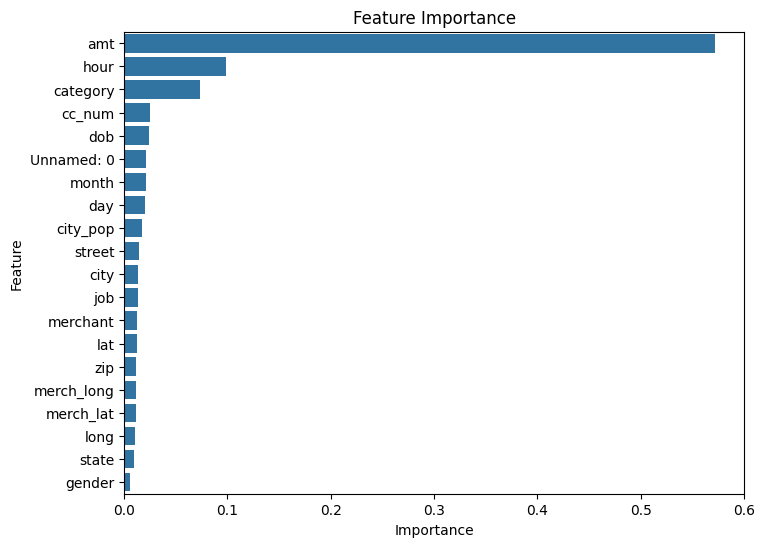

In [9]:
# Extract feature importance from the trained model
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print feature importance
print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

Comparison in Models

In [10]:
# Add predictions to the test dataset
test_data['predicted_is_fraud'] = y_pred

# Filter records predicted as fraud
predicted_fraud_records = test_data[test_data['predicted_is_fraud'] == 1]

# Display the filtered records
print("\nRecords Predicted as Fraud:")
print(predicted_fraud_records)

# Save the fraud records to a CSV file
predicted_fraud_records.to_csv("C:/Users/Mayank Goel/OneDrive/Desktop/ML Lab/predicted_fraud_records.csv", index=False)

print("\nFraud records saved to 'predicted_fraud_records.csv'")


Records Predicted as Fraud:
        Unnamed: 0 trans_date_trans_time            cc_num  \
1695          1695   2020-06-21 22:09:41     4427805710168   
1767          1767   2020-06-21 22:32:22  6564459919350820   
1781          1781   2020-06-21 22:37:27  6564459919350820   
1784          1784   2020-06-21 22:38:55  4005676619255478   
1857          1857   2020-06-21 23:02:16  3560725013359375   
...            ...                   ...               ...   
517524      517524   2020-12-22 23:05:39    38052002992326   
517529      517529   2020-12-22 23:06:03  2242176657877538   
517571      517571   2020-12-22 23:13:39  2242176657877538   
524263      524263   2020-12-25 01:50:25  3595192916105588   
542947      542947   2020-12-28 23:24:17  3512365128314616   

                                   merchant       category      amt gender  \
1695                 fraud_Lebsack and Sons       misc_net   890.22      F   
1767      fraud_Rodriguez, Yost and Jenkins       misc_net   780.52   

Visualize the Fraud records

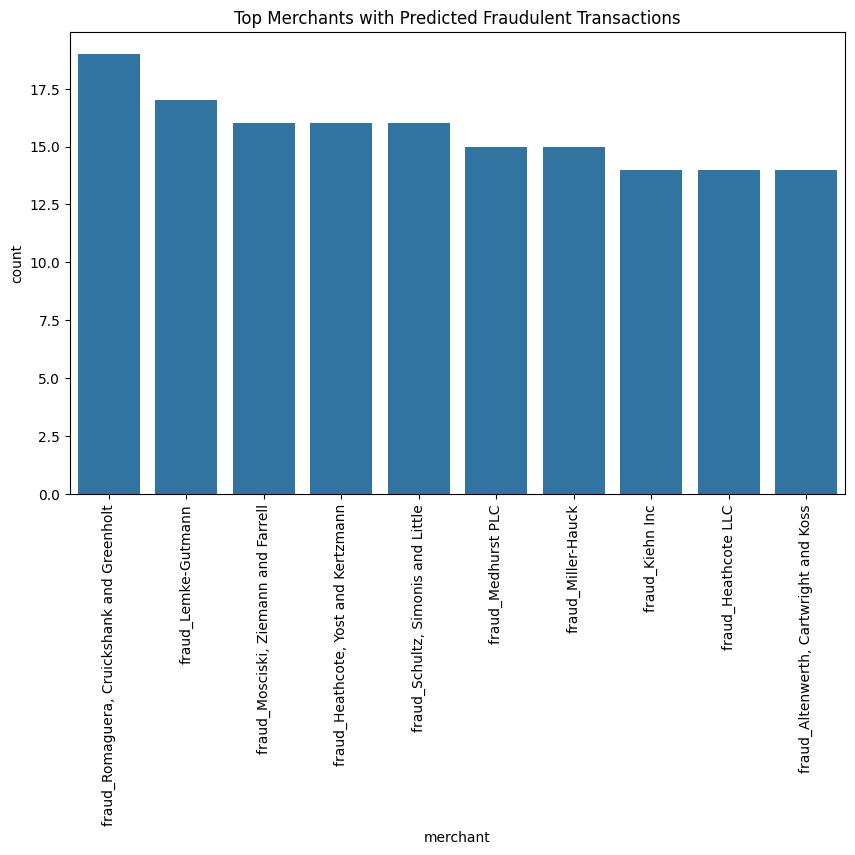

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=predicted_fraud_records, x='merchant', order=predicted_fraud_records['merchant'].value_counts().index[:10])
plt.title('Top Merchants with Predicted Fraudulent Transactions')
plt.xticks(rotation=90)
plt.show()

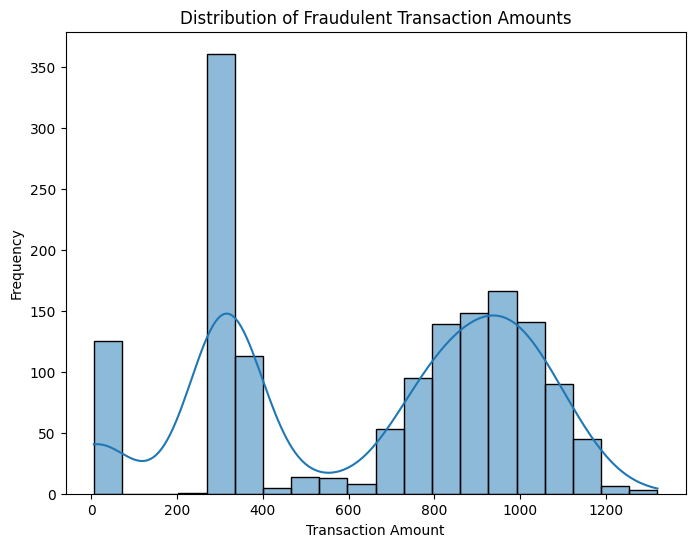

In [12]:
# Fraud Amount Distribution
plt.figure(figsize=(8, 6))
sns.histplot(predicted_fraud_records['amt'], bins=20, kde=True)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()